In [2]:
import numpy as np
import pandas as pd
import os
import math
from tqdm import tqdm
from sympy import *
import random
from ast import literal_eval
import itertools 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import copy

In [3]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
FOLDERNAME =  '종설/'

assert FOLDERNAME is not None, 'ERROR'

%cd drive/My\ Drive
%cp -r $FOLDERNAME ../../

Mounted at /content/drive
/content/drive/My Drive
cp: cannot open '종설/small_data.csv.gsheet' for reading: Operation not supported


In [4]:
## 데이터 사이즈 비교하여 실험 할것 + 딜레이 추가하는 것도?
usingdata = pd.read_csv('data_hr.csv',index_col = 0,encoding = "UTF-8")

num_vessel = usingdata.shape[0]


In [33]:
num_generations = 80 #논문 1000
population_size = 20 #논문 500
mutation_rate = 0.2 #논문0.1

In [6]:
usingdata

,ATB,ATD,Total,ETB,ETD,배길이(m),Delay
선박명,,,,,,,
MING YUE,1.4,11.0,187,0.0,11.0,81,0.0
REVERENCE,3.5,17.0,966,3.0,17.0,142,0.0
YA LU JIANG,15.0,19.5,102,15.0,19.0,110,0.5
SUNNY CAMELLIA,16.5,28.0,632,16.0,28.0,141,0.0
WAN HAI 317,25.5,41.0,837,25.0,41.0,212,0.0
HANSUNG INCHEON,29.0,38.0,349,29.0,38.0,137,0.0
SKY RAINBOW,30.0,41.9,607,30.0,41.0,172,0.9
XIN MING ZHOU 20,51.0,84.0,1132,50.0,84.0,143,0.0
POS BANGKOK,54.0,78.0,885,53.0,78.0,172,0.0


In [7]:

qcmax_list = []
positionmax_list = []

for i in range(num_vessel):
    ves_length = usingdata.iloc[i]['배길이(m)']
    
    positionmax_list.append(780-ves_length)
    if ves_length < 50 :
        qcmax_list.append(2)
    elif ves_length < 100:
        qcmax_list.append(3)
    else:
        qcmax_list.append(4)

usingdata['maxposition'] = positionmax_list
usingdata['maxQC'] = qcmax_list

In [8]:
usingdata

,ATB,ATD,Total,ETB,ETD,배길이(m),Delay,maxposition,maxQC
선박명,,,,,,,,,
MING YUE,1.4,11.0,187,0.0,11.0,81,0.0,699.0,3
REVERENCE,3.5,17.0,966,3.0,17.0,142,0.0,638.0,4
YA LU JIANG,15.0,19.5,102,15.0,19.0,110,0.5,670.0,4
SUNNY CAMELLIA,16.5,28.0,632,16.0,28.0,141,0.0,639.0,4
WAN HAI 317,25.5,41.0,837,25.0,41.0,212,0.0,568.0,4
HANSUNG INCHEON,29.0,38.0,349,29.0,38.0,137,0.0,643.0,4
SKY RAINBOW,30.0,41.9,607,30.0,41.0,172,0.9,608.0,4
XIN MING ZHOU 20,51.0,84.0,1132,50.0,84.0,143,0.0,637.0,4
POS BANGKOK,54.0,78.0,885,53.0,78.0,172,0.0,608.0,4


In [9]:
def generate_initial_pop(df, N): #N개의 chromosome generation
  initial = []
  for i in range(N):
    chromosome = []
    for j in range(len(df)):
      vessel = []
      vessel.append(j)
      qcmax = df.iloc[j]['maxQC']
      a = random.randint(1,qcmax)
      vessel.append(a)

      start_point = 20 # safety distance 적용 
      end_point = df.iloc[j]['maxposition']
      
      b = random.randint(start_point,end_point)
      vessel.append(b)
      chromosome.append(vessel)
    random.shuffle(chromosome)
    initial.append(chromosome)

  return initial


In [10]:
def mutation(offspring, df):
  #mutation_generation = []
  
  #for m in range(len(next_generation)):
    # random값(0,1사이) 0.2보다 작을때 mutation 진행
  if random.random() < 0.2:
    k=random.randint(1,len(offspring)-3) # 첫번째 mutation point
    h=random.randint(k+1,len(offspring)-1) # 두번째 mutation point

    front = [] # mutation 안되는 앞 부분
    tail = [] # mutation 안되는 뒷 부분

    for i in range(0,k):
      front.append(offspring[i])

    for i in range(h+1,len(offspring)):
      tail.append(offspring[i])

    mutation_temp = [] # mutation되는 중간 부분, shuffle 이용 
    for i in range(k,h+1):
      mutation_temp.append(offspring[i])  
    random.shuffle(mutation_temp)

    for i in range(len(mutation_temp)): # QC, position 재할당 
      ves_num = mutation_temp[i][0]
      qcmax = df.iloc[ves_num]['maxQC']
      a = random.randint(1,qcmax)
      mutation_temp[i][1] = a
      start_point = 20
      end_point = df.iloc[ves_num]['maxposition']
      b = random.randint(start_point,end_point)
      mutation_temp[i][2] = b
    
    mut_offspring = front + mutation_temp + tail
    #mutation_generation.append(mutation_chromosome)
    
  else: # random값이 0.2보다 크면 그대로 mutation_generation에 append
    mut_offspring = offspring

  return mut_offspring

In [11]:
def crossover(mom_in, dad_in, df):
    
    mom = copy.deepcopy(mom_in)
    dad = copy.deepcopy(dad_in)

    chrms_len = len(mom)
    
    mom_seq = []
    dad_seq = []
    for i in range(chrms_len):
        mom_seq.append(mom[i][0])
        dad_seq.append(dad[i][0])

    crovp_1, crovp_2 = random.sample(range(chrms_len), 2)
    if crovp_1 > crovp_2:
        tmp = crovp_1
        crovp_1 = crovp_2
        crovp_2 = tmp
    #print("point",crovp_1,crovp_2)

    to_dau_fm = mom[crovp_1:crovp_2]
    to_son_fd = dad[crovp_1:crovp_2]
    to_dau_fd_1 = dad[:crovp_1]
    to_dau_fd_2 = dad[crovp_2:]
    to_son_fm_1 = mom[:crovp_1]
    to_son_fm_2 = mom[crovp_2:]

    son = copy.deepcopy(to_son_fm_1 + to_son_fd +to_son_fm_2)
    daughter = copy.deepcopy(to_dau_fd_1 + to_dau_fm + to_dau_fd_2)

    # print("기본 son", son)
    # print("기본 딸", daughter)
    # print("mom", mom)
    ##validation check
    #아들은 아빠, 딸은 엄마로 부터 받은 것은 바뀌지 않는다.
    #해당 vessel number 저장
    son_main = []
    dau_main = []
    for i in range(len(to_son_fd)):
        son_main.append(to_son_fd[i][0])
        dau_main.append(to_dau_fm[i][0])
    # print("아들 메인", son_main)
    # print("딸 메인", dau_main)

    #아들과 딸의 chromosome에서 main과 겹치는 gene의 index 저장
    son_inf_list = []
    dau_inf_list = []    
    for j in range(len(to_son_fm_1)):
        if to_son_fm_1[j][0] in son_main:
            son_inf_list.append(j)
        if to_dau_fd_1[j][0] in dau_main:
            dau_inf_list.append(j)
    for k in range(len(to_son_fm_2)):
        if to_son_fm_2[k][0] in son_main:
            son_inf_list.append(crovp_2+k)
        if to_dau_fd_2[k][0] in dau_main:
            dau_inf_list.append(crovp_2+k)

    # print("아들 inf1",son_inf_list)
    # print("딸 inf1", dau_inf_list)
    # print("mom", mom)
    # 해당 index에 대해 gene을 modify, 해당과 겹치는 다른 gene의 index저장
    son_inf_list2 = []
    
    for inf in son_inf_list:
        son[inf][0] = dad_seq[inf]
        son[inf][1] = int(min(son[inf][1],df.iloc[dad_seq[inf]]['maxQC']))
        son[inf][2] = int(min(son[inf][2],df.iloc[dad_seq[inf]]['maxposition']))
        for i in range(chrms_len):
            if i != inf and son[i][0] not in son_main and son[i][0] == son[inf][0]:
                son_inf_list2.append(i)
    
    dau_inf_list2 = []
    for inf2 in dau_inf_list:
        #print("inf2", inf2, mom_seq[inf2])
        daughter[inf2][0] = mom_seq[inf2]
        #print("done", daughter[inf2])
        daughter[inf2][1] = int(min(daughter[inf2][1],df.iloc[mom_seq[inf2]]['maxQC']))
        daughter[inf2][2] = int(min(daughter[inf2][2],df.iloc[mom_seq[inf2]]['maxposition']))
        for j in range(chrms_len):
            if j != inf2 and daughter[j][0] not in dau_main and daughter[j][0] == daughter[inf2][0]:
                dau_inf_list2.append(j)
                #print("!!")

    # print("아들", son)
    # print("아들 inf2", son_inf_list2)

    # print("딸", daughter)
    # print("딸 inf2", dau_inf_list2)
    
    son_set = set()
    dau_set = set()
    ves_set = set(range(chrms_len))
    for i in range(chrms_len):
        son_set.add(son[i][0])
        dau_set.add(daughter[i][0])
    
    son_not_in = list(ves_set - son_set)
    dau_not_in = list(ves_set - dau_set)

    # print(son_not_in)
    # print(dau_not_in)
    
    for i in range(len(son_inf_list2)):
        idx = son_inf_list2[i]
        son[idx][0] = son_not_in[i]
        son[idx][1] = int(min(son[idx][1], df.iloc[son[idx][0]]['maxQC']))
        son[idx][2] = int(min(son[idx][2], df.iloc[son[idx][0]]['maxposition']))
    #print(dau_inf_list2)
    for i in range(len(dau_inf_list2)):
        idx = dau_inf_list2[i]
        daughter[idx][0] = dau_not_in[i]
        daughter[idx][1] = int(min(daughter[idx][1], df.iloc[daughter[idx][0]]['maxQC']))
        daughter[idx][2] = int(min(daughter[idx][2], df.iloc[daughter[idx][0]]['maxposition']))


    return daughter, son

In [22]:
#Paramaters
N = num_vessel       #total vessel number
gap_y = 20  #distance interval(unit = meter) 
gap_x = 1   #time interval(unit = minute)
T = 110      #planning period
L = 800     #quay length
Q = 7       #total QC numbers
qmin = 1    #minimum QC/hr for vessel i
qmax = 4    #maximum QC/hr for vessel i
p = 27.5    #productivity  ####################################################25~30 사이 적당한 값 찾아보기!
M = 1e12        #big M
l = np.array(usingdata['배길이(m)']) #vessel length
r = np.array(usingdata['Total'])     #total container numbers
ETA = np.array(usingdata['ETB']).astype(int)     #ETA for vessel i
ETD = np.array(usingdata['ETD'])     #ETD for vessel i

In [13]:
def debugging_func(data):
  for i in range(len(data) - 1):
    print("vessel {}의 berthing time: {}, processing time: {}".format(data[i][2], data[i][0], data[i][1]))
  print('----')

In [23]:
# arr은 이제 입력을 받을 2차원 리스트라고 생각하고 구현을 진행하였음 -> [[], [], []....]
# 하나의 array에는 각 인덱스가 해당하는 값 0 : vessel num, 1 : 할당된 qc의 개수, 2: 할당 된 위치
# arr : list
# N : 7개 scalar(배)
# Q : 7 scalar -> 어떤 시점을 보았을 때 qc가 7개를 넘어간다면, 이를 피해서 할당 할 수 있어야함.
# L : 800m scalar -> 만약 m를 넘어가는 것을 고려해야함
# T : 42 scalar -> 만약 시간 할 당 중 T를 넘어가는 case가 넘어가면>? -> break?
# p : 25 scalar
# r : r[i] = vessel i가 처리할 컨테이너의 개수 -> list
# l : l[i] = vessel i의 길이 -> list
# ETD: ETD[i] = vessel i의 ETD를 저장하는 것
# ETA: ETA[i] = vessel i의 ETA를 저장하는 것

def getFitnessValue(arr, N, Q, L, T, p, r, l, ETD, ETA):
  board = [[0 for col in range(T + 10000)] for row in range(L + 1)] # 여기에 숫자를 매겨서 어디 시점에 어디 위치에 어떤 배가 있는지 나타내는 식으로 구현을 진행 -> 이 요소들은 절대 바뀌어서는 안 됨
  cur_qc_assigned = [0 for _ in range(T + 10000)] # 현재 시점 i에 할당된 qc의 개수
  fitness_value = 0 # 여기에 fitness value를 계산해서 return을 할 것
  dep_time = [0] * (N + 1)
  debugging_list = [[0 for _ in range(0, 3)] for i in range(0, N + 1)]


  for i in range(len(arr)):
    num = arr[i][0] #현재 vessel 번호
    qc = arr[i][1] #현재 할당될 qc의 개수
    pos = arr[i][2] #현재 할당될 vessel의 위치
    # print("{} {} {}".format(num, qc, pos))

    fixed_pos = pos
    fixed_time = ETA[num]
    processing_time = math.ceil(r[num] / (p * qc))

    # 이 위치에 berthing이 가능한지 확인
    while True:
      flag = True # 지금 여기에 berthing 가능하다 해보자

      # if fixed_time > T:
      #   break

      if board[fixed_pos][fixed_time] == 0:
        for j in range(fixed_pos + 1, fixed_pos + l[num] + 1):
          for k in range(fixed_time, fixed_time + processing_time + 1):
            # if k > T:
            #   flag = False
            #   break

            if board[j][k] != 0:
              flag = False
              break
            
          if flag == False:
            break

      else:
        fixed_time += 1
        continue

      if flag == False: # 현재는 접안이 불가능, 시간을 미루기
        fixed_time += 1

      else: # 가능해를 찾은 것!
        break

    # 불가능한 케이스 (시간 T를 넘어가는 경우)
    # if fixed_time > T:
    #   return M


    # qc를 놓을 수 있는지 판단하고 좌표 찾기
    while True:
      flag = True # 접안이 가능하다 가정
      if cur_qc_assigned[fixed_time] <= Q - qc: # qc 할당이 가능함
        for a in range(fixed_time, fixed_time + processing_time + 1):
          if cur_qc_assigned[a] > Q - qc:
            flag = False
            break

        if flag == False:
          fixed_time += 1
          continue

        else: # 접안 가능 위치를 찾음
          break
      
      else: # qc 할당이 불가능
        fixed_time += 1

        # if fixed_time >= T:
        #   break

    # fitness value = 작을 수록 좋은 것
    # 이제 fixed_time 부터 processing time동안, fixed_pos부터 l[i] 까지의 반복문을 통해 board에 i + 1을 투입하는 식으로 구현

    for j in range(fixed_time , fixed_time + processing_time + 1):
      # 불가능한 케이스 (시간 T를 넘어가는 경우)
      # if j > T:
      #   return M

      for k in range(fixed_pos, fixed_pos + l[num] + 1):
        board[k][j] = num + 1
      cur_qc_assigned[j] += qc
 
    
    # 여기서 이제 dep_time에 해당되는 departure time을 저장
    dep_time[num] = fixed_time + processing_time
    debugging_list[i][0] = fixed_time
    debugging_list[i][1] = processing_time
    debugging_list[i][2] = num

  # iteration이 배에 대해서 모두 끝나면, 여기서 이제 fitness value를 계산해서 return
  for a in range(0, N): # vessel 개수에 맞춰서 fitness value 계산 후 return
    fitness_value += (max(0, r[a]*15*(dep_time[a] - ETD[a])))

  #debugging_func(debugging_list)
  return fitness_value

In [29]:
# arr은 이제 입력을 받을 2차원 리스트라고 생각하고 구현을 진행하였음 -> [[], [], []....]
# 하나의 array에는 각 인덱스가 해당하는 값 0 : vessel num, 1 : 할당된 qc의 개수, 2: 할당 된 위치
# arr : list
# N : 7개 scalar(배)
# Q : 7 scalar -> 어떤 시점을 보았을 때 qc가 7개를 넘어간다면, 이를 피해서 할당 할 수 있어야함.
# L : 800m scalar -> 만약 m를 넘어가는 것을 고려해야함
# T : 42 scalar -> 만약 시간 할 당 중 T를 넘어가는 case가 넘어가면>? -> break?
# p : 25 scalar
# r : r[i] = vessel i가 처리할 컨테이너의 개수 -> list
# l : l[i] = vessel i의 길이 -> list
# ETD: ETD[i] = vessel i의 ETD를 저장하는 것
# ETA: ETA[i] = vessel i의 ETA를 저장하는 것

def getFitnessValue2(arr, N, Q, L, T, p, r, l, ETD, ETA):
  board = [[0 for col in range(T + 10000)] for row in range(L + 1)] # 여기에 숫자를 매겨서 어디 시점에 어디 위치에 어떤 배가 있는지 나타내는 식으로 구현을 진행 -> 이 요소들은 절대 바뀌어서는 안 됨
  cur_qc_assigned = [0 for _ in range(T + 10000)] # 현재 시점 i에 할당된 qc의 개수
  fitness_value = 0 # 여기에 fitness value를 계산해서 return을 할 것
  dep_time = [0] * (N + 1)
  debugging_list = [[0 for _ in range(0, 3)] for i in range(0, N + 1)]


  for i in range(len(arr)):
    num = arr[i][0] #현재 vessel 번호
    qc = arr[i][1] #현재 할당될 qc의 개수
    pos = arr[i][2] #현재 할당될 vessel의 위치
    # print("{} {} {}".format(num, qc, pos))

    fixed_pos = pos
    fixed_time = ETA[num]
    processing_time = math.ceil(r[num] / (p * qc))

    # 이 위치에 berthing이 가능한지 확인
    while True:
      flag = True # 지금 여기에 berthing 가능하다 해보자

      # if fixed_time > T:
      #   break

      if board[fixed_pos][fixed_time] == 0:
        for j in range(fixed_pos + 1, fixed_pos + l[num] + 1):
          for k in range(fixed_time, fixed_time + processing_time + 1):
            # if k > T:
            #   flag = False
            #   break

            if board[j][k] != 0:
              flag = False
              break
            
          if flag == False:
            break

      else:
        fixed_time += 1
        continue

      if flag == False: # 현재는 접안이 불가능, 시간을 미루기
        fixed_time += 1

      else: # 가능해를 찾은 것!
        break

    # 불가능한 케이스 (시간 T를 넘어가는 경우)
    # if fixed_time > T:
    #   return M


    # qc를 놓을 수 있는지 판단하고 좌표 찾기
    while True:
      flag = True # 접안이 가능하다 가정
      if cur_qc_assigned[fixed_time] <= Q - qc: # qc 할당이 가능함
        for a in range(fixed_time, fixed_time + processing_time + 1):
          if cur_qc_assigned[a] > Q - qc:
            flag = False
            break

        if flag == False:
          fixed_time += 1
          continue

        else: # 접안 가능 위치를 찾음
          break
      
      else: # qc 할당이 불가능
        fixed_time += 1

        # if fixed_time >= T:
        #   break

    # fitness value = 작을 수록 좋은 것
    # 이제 fixed_time 부터 processing time동안, fixed_pos부터 l[i] 까지의 반복문을 통해 board에 i + 1을 투입하는 식으로 구현

    for j in range(fixed_time , fixed_time + processing_time + 1):
      # 불가능한 케이스 (시간 T를 넘어가는 경우)
      # if j > T:
      #   return M

      for k in range(fixed_pos, fixed_pos + l[num] + 1):
        board[k][j] = num + 1
      cur_qc_assigned[j] += qc
 
    
    # 여기서 이제 dep_time에 해당되는 departure time을 저장
    dep_time[num] = fixed_time + processing_time
    debugging_list[i][0] = fixed_time
    debugging_list[i][1] = processing_time
    debugging_list[i][2] = num

  # iteration이 배에 대해서 모두 끝나면, 여기서 이제 fitness value를 계산해서 return
  delaytime = 0 
  for a in range(0, N): # vessel 개수에 맞춰서 fitness value 계산 후 return
    fitness_value += (max(0, r[a]*15*(dep_time[a] - ETD[a])))
    delaytime += (max(0, (dep_time[a] - ETD[a])))
  debugging_func(debugging_list)
  return fitness_value, delaytime

In [34]:
best_chrms_list = []

generation_num = list(range(num_generations))
generation_best_fitness = pd.DataFrame(index = generation_num, columns = ['best_fit'])
generation_best_fitness.iloc[:,:] = 0
generation_best_fitness

,best_fit
0,0
1,0
2,0
3,0
4,0
...,...
75,0
76,0
77,0
78,0


[[[9, 1, 249], [15, 4, 371], [1, 4, 171], [3, 4, 67], [4, 2, 530], [5, 3, 385], [7, 4, 623], [10, 4, 120], [13, 1, 197], [8, 2, 457], [0, 2, 95], [11, 1, 192], [6, 4, 576], [2, 2, 554], [12, 2, 228], [14, 2, 366]], [[2, 4, 114], [15, 3, 129], [9, 3, 179], [4, 3, 289], [12, 3, 463], [3, 2, 163], [11, 1, 373], [7, 4, 241], [10, 3, 257], [5, 4, 239], [6, 2, 245], [1, 4, 296], [8, 1, 543], [14, 3, 305], [13, 2, 343], [0, 1, 536]], [[10, 4, 45], [12, 2, 457], [11, 3, 400], [7, 2, 236], [3, 1, 247], [0, 2, 209], [6, 3, 506], [4, 4, 487], [5, 3, 166], [2, 2, 231], [15, 2, 478], [13, 3, 243], [14, 4, 363], [9, 1, 67], [1, 2, 347], [8, 2, 348]], [[12, 1, 55], [4, 1, 25], [6, 1, 372], [10, 4, 516], [9, 3, 428], [8, 1, 115], [7, 2, 507], [11, 4, 557], [3, 2, 157], [1, 2, 226], [15, 4, 626], [5, 4, 131], [2, 2, 592], [0, 1, 110], [14, 3, 140], [13, 1, 53]], [[8, 1, 498], [12, 3, 414], [13, 2, 481], [6, 4, 55], [7, 2, 380], [9, 3, 415], [11, 4, 59], [1, 2, 38], [10, 3, 542], [14, 2, 173], [4, 1, 41

<Axes: >

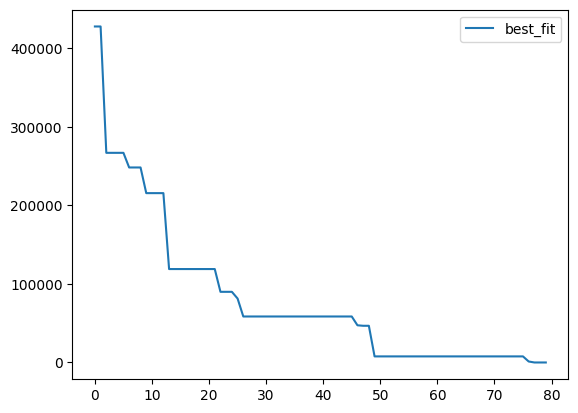

In [35]:
population = generate_initial_pop(usingdata, 20) # 초기해 생성
print(population)
for u in range(80): # 세대수 40세대
    init_pop = copy.deepcopy(population)
    
    random.shuffle(init_pop)
    #print(init_pop)
    next_gen = [] # 세대마다 생기는 crossover, mutation 결과 리스트 생성
    aaaa=[]
    for i in range(0,20,2): # population 정렬 순서대로 (0,1),(2,3),(4,5)~~(18,19) crossover 및 mutation
        mom = copy.deepcopy(init_pop[i])
        dad = copy.deepcopy(init_pop[i+1])
        dal, adl = crossover(init_pop[i], init_pop[i+1], usingdata)
        dal = mutation(dal, usingdata)
        adl = mutation(adl, usingdata)
    
        if getFitnessValue(mom, N, Q, L, T, p, r, l, ETD, ETA) < getFitnessValue(dal, N, Q, L, T, p, r, l, ETD, ETA):
            next_gen.append(mom)
            aaaa.append(getFitnessValue(mom, N, Q, L, T, p, r, l, ETD, ETA))
        else: 
            next_gen.append(dal)
            aaaa.append(getFitnessValue(dal, N, Q, L, T, p, r, l, ETD, ETA))
        if getFitnessValue(dad, N, Q, L, T, p, r, l, ETD, ETA) < getFitnessValue(adl, N, Q, L, T, p, r, l, ETD, ETA):
            next_gen.append(dad)
            aaaa.append(getFitnessValue(dad, N, Q, L, T, p, r, l, ETD, ETA))
        else: 
            next_gen.append(adl)
            aaaa.append(getFitnessValue(adl, N, Q, L, T, p, r, l, ETD, ETA))
    print(aaaa)
    #print(next_gen)
    best_fitval = min(aaaa)
    print(best_fitval)
    
    best_chrms_list.append(next_gen[aaaa.index(min(aaaa))])
    
    generation_best_fitness.iloc[u, 0] = best_fitval
    # chromosome_number = []
    # for i in range(20): #chromosome_fitness df 생성
    #     chromosome_number.append(i)
    # chromosome_fitness = pd.DataFrame(index = chromosome_number, columns = ['fitness'])
    # chromosome_fitness.iloc[:,:] = 0
    # chromosome_fitness.insert(0,'chromosome_num',0)
    
    # for i in range(len(chromosome_number)): #chromosome_num df에 추가
    #     chromosome_fitness.iloc[i,0] = i
    
    # for x in range(len(next_gen)): #fitness value 구해서 chromosome_fitness df로 삽입
    #     fit_val = getFitnessValue(next_gen[x], N, Q, L, T, p, r, l, ETD, ETA)
    #     chromosome_fitness.loc[x, 'fitness'] = fit_val
    # chromosome_fitness['fitness'] = chromosome_fitness['fitness'].astype(int) # 필요한지 모르겠음
    
    # chromosome_fit = chromosome_fitness.sort_values(by='fitness')
    # next_generation = []
    # half = chromosome_fit.nsmallest(20,'fitness',keep='first') # fitness값 작은순으로 순서대로 정렬 후 상위 50% half에 추가 ## fit 값 음수양수 바뀌면 수정해야됨
    
    # for i in range(len(chromosome_fit)): #half에 있는 chromosome을 total_population에서 추출하고 next_generation에 삽입 
    #     if i in half['chromosome_num']:
    #         next_generation.append(total_population[i])
            
    # generation_best_fitness.iloc[u,0] = half.iloc[0,1] #세대별 fitness 최대 값 추출해서 generation_best_fitness df에 삽입
    
    # top = half.iloc[0,0]
    # print("Best Schedule:", total_population[top]) # 돌아가면 주석처리
    population = next_gen # 현재 next generation으로 결정된 chromosome들을 다음세대 population으로 저장하고 다음세대로

print("Best chromosome: ", best_chrms_list[-1])
sol1, sol2 = getFitnessValue2(best_chrms_list[-1], N, Q, L, T, p, r, l, ETD, ETA)
print("Best Schedule's fitness value:", sol1, "Delay time is ", sol2)
# print("fitness value: ", generation_best_fitness.iloc[u]['best_fit'])
generation_best_fitness.plot()

In [36]:
generation_best_fitness

,best_fit
0,427950.0
1,427950.0
2,267015.0
3,267015.0
4,267015.0
...,...
75,7740.0
76,1260.0
77,0
78,0


<Axes: >

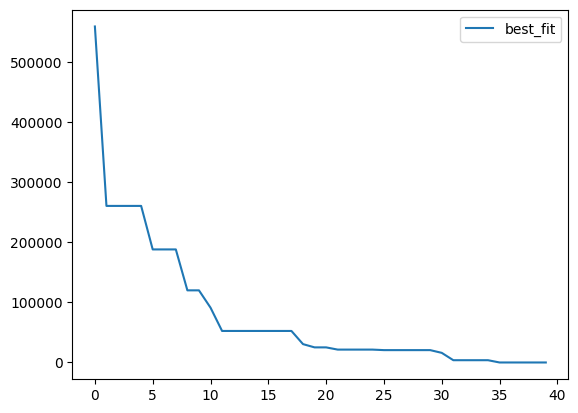

In [21]:
generation_best_fitness.plot()